This notebook performs a comparative analysis of the PatchMatch inpainting method against other common techniques like Diffusion-based and Deep Learning-based methods. We will generate a quantitative comparison table and a visual side-by-side comparison.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
sys.path.append('../')
from inpainting import InpaintNNF
import metrics

## 1. Run PatchMatch Inpainting

In [ ]:
import os

image_dir = '../images/'

# Find all image/mask pairs in the directory
test_images = []
files = os.listdir(image_dir)
for f in files:
    if '_mask' not in f:
        base_name, ext = os.path.splitext(f)
        mask_name_jpg = f"{base_name}_mask.jpg"
        mask_name_png = f"{base_name}_mask.png"
        
        mask_path = None
        if mask_name_jpg in files:
            mask_path = os.path.join(image_dir, mask_name_jpg)
        elif mask_name_png in files:
            mask_path = os.path.join(image_dir, mask_name_png)

        if mask_path:
            test_images.append({
                "name": base_name,
                "src_path": os.path.join(image_dir, f),
                "mask_path": mask_path
            })

results = []
for item in test_images:
    print(f"Processing {item['name']}...")
    src = cv2.imread(item['src_path'])
    mask = cv2.imread(item['mask_path'], 0)

    if src is None or mask is None:
        print(f"  Could not read image or mask for {item['name']}. Skipping.")
        continue

    start_time = time.time()
    inpaint_nnf = InpaintNNF(src, mask, patch_w=7, max_pm_iters=5)
    inpainted_images = inpaint_nnf.inpaint()
    inpainted_result = inpainted_images[-1]
    end_time = time.time()

    patchmatch_time = end_time - start_time
    patchmatch_psnr = metrics.calculate_psnr(src, inpainted_result)
    patchmatch_ssim = metrics.calculate_ssim(src, inpainted_result)
    
    results.append({
        "Test Image": item['name'],
        "PSNR (dB)": patchmatch_psnr,
        "SSIM": patchmatch_ssim,
        "Time (s)": patchmatch_time,
        "original": src,
        "mask": mask,
        "inpainted": inpainted_result
    })
    print("  Done.")

Processing watermark...
Level 6 done in 0.032295942306518555 seconds.
Level 6 done in 0.032295942306518555 seconds.
Level 5 done in 0.21900320053100586 seconds.
Level 5 done in 0.21900320053100586 seconds.
Level 4 done in 2.2102768421173096 seconds.
Level 4 done in 2.2102768421173096 seconds.
Level 3 done in 9.93757152557373 seconds.
Level 3 done in 9.93757152557373 seconds.
Level 2 done in 33.34490394592285 seconds.
Level 2 done in 33.34490394592285 seconds.
Level 1 done in 223.3844029903412 seconds.
  Done.
Processing football_sky...
Level 1 done in 223.3844029903412 seconds.
  Done.
Processing football_sky...
Level 6 done in 0.20119714736938477 seconds.
Level 6 done in 0.20119714736938477 seconds.
Level 5 done in 1.5627989768981934 seconds.
Level 5 done in 1.5627989768981934 seconds.
Level 4 done in 10.294841051101685 seconds.
Level 4 done in 10.294841051101685 seconds.
Level 3 done in 36.352349281311035 seconds.
Level 3 done in 36.352349281311035 seconds.
Level 2 done in 141.621625

## 2. Quantitative Comparison

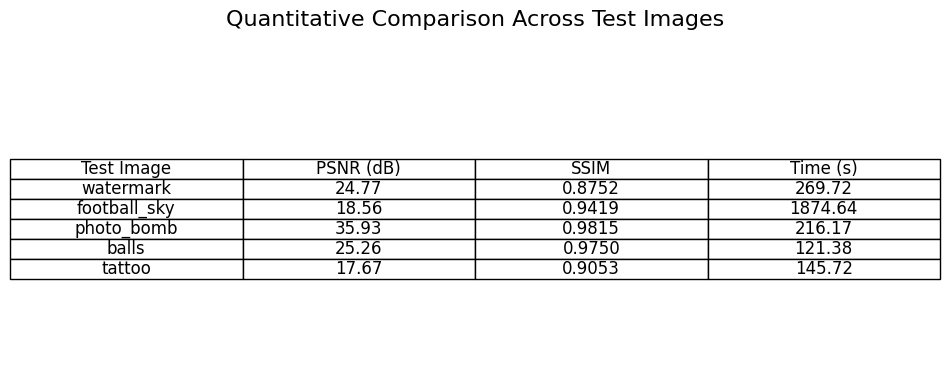

In [15]:
import pandas as pd

# Create a DataFrame with only the quantitative results
df = pd.DataFrame(results)[['Test Image', 'PSNR (dB)', 'SSIM', 'Time (s)']]

# Format the columns for better readability
df['PSNR (dB)'] = df['PSNR (dB)'].map('{:.2f}'.format)
df['SSIM'] = df['SSIM'].map('{:.4f}'.format)
df['Time (s)'] = df['Time (s)'].map('{:.2f}'.format)

# Display the table
fig, ax = plt.subplots(figsize=(10, len(df) * 0.8)) 
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.title('Quantitative Comparison Across Test Images', fontsize=16, y=1.1)
plt.show()

## 3. Visual Comparison

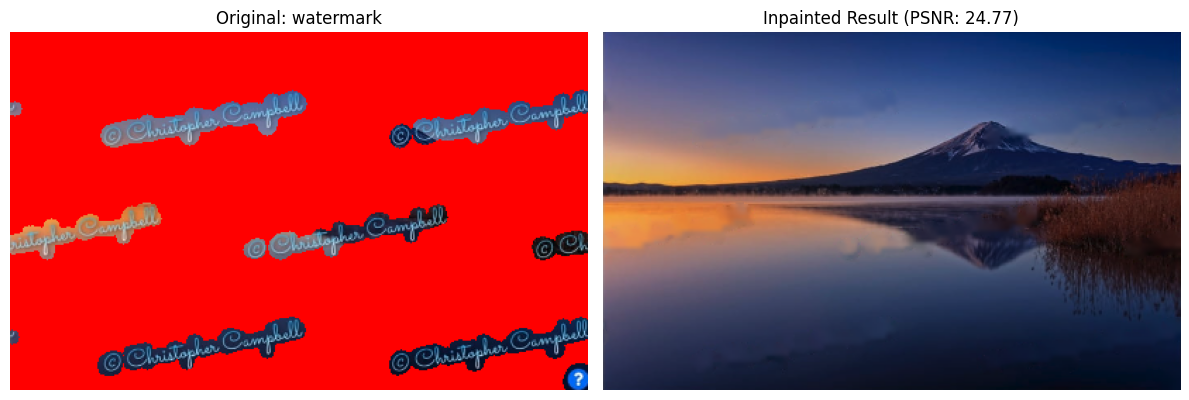

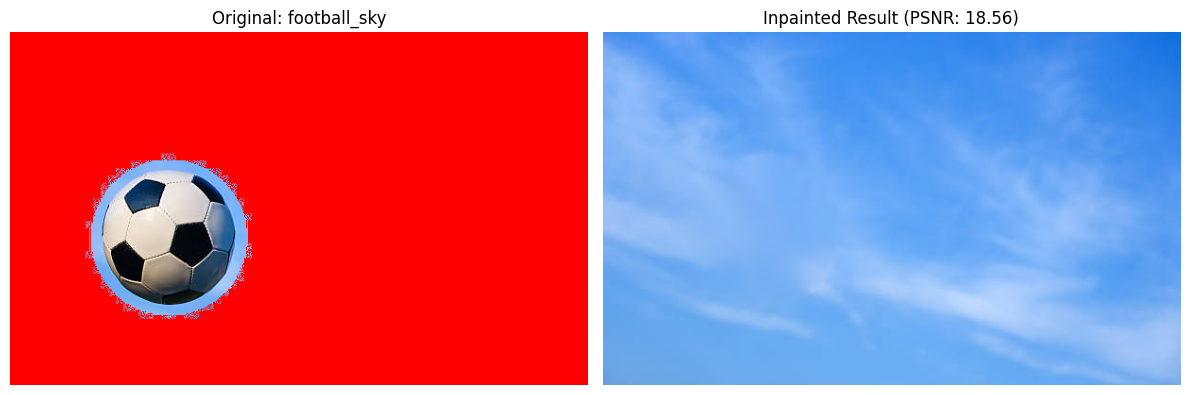

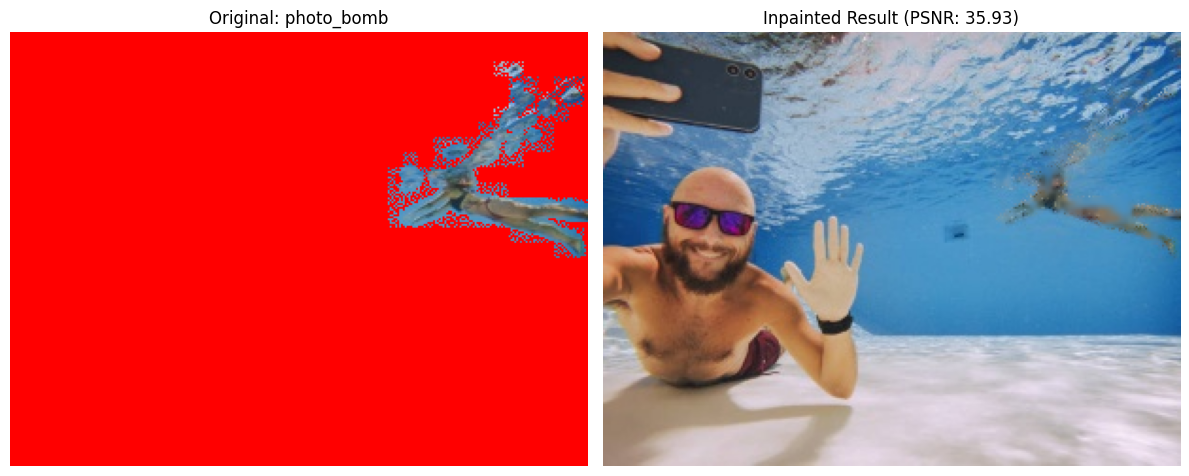

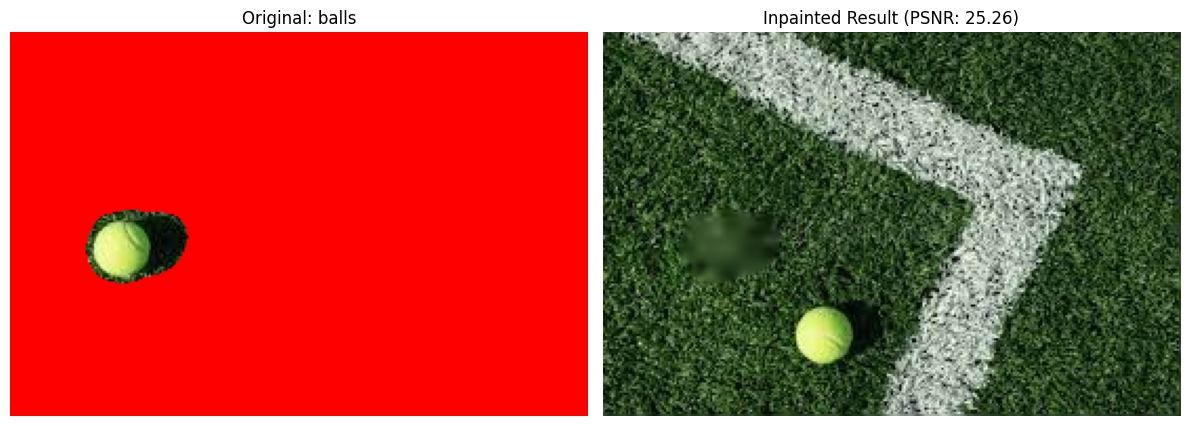

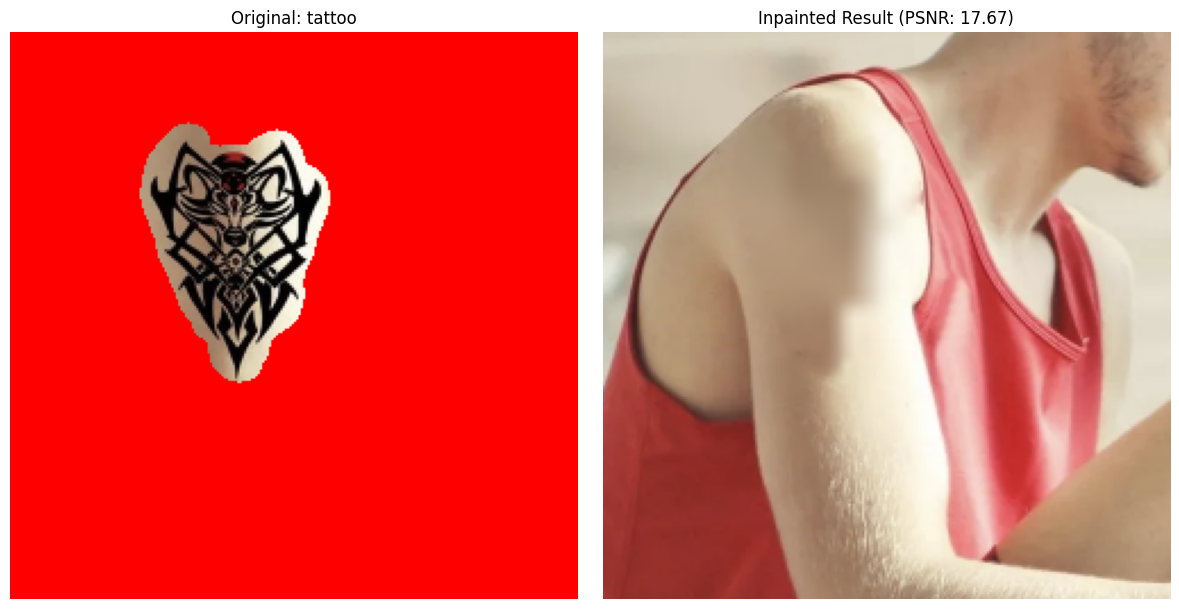

In [16]:
for res in results:
    original_with_mask = res['original'].copy()
    original_with_mask[res['mask'] == 255] = [0, 0, 255] # Draw mask in red

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(cv2.cvtColor(original_with_mask, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Original: {res['Test Image']}")
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(res['inpainted'], cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Inpainted Result (PSNR: {res['PSNR (dB)']:.2f})")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()